In [4]:
import dolfin as dl
import numpy as np
import pandas as pd

# from datetime import datetime
import datetime
# from seird_problem import seird_fwd_problem
# from seird_initial_with_recovered import generate_initial_condition

import os
import sys
import copy

import argparse
import timeit

In [5]:
import pyvista as pv
import geopandas as gpd
from shapely.geometry import Point
from descartes import PolygonPatch

from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.5, rc={'text.usetex' : True})
sns.set_style("white")
sns.set_style("ticks")

In [7]:
STATE = 0
PARAMETER = 1

fwd_path = '../../Model/seird/'
mesh_path = '../../Data/mesh/'
data_path = '../../Data/covid_7July2020/'
ic_path = '../../Model/ic_result/'

num_sim = 1
sim_id = 0

date = "2020-06-01"

# Plot QoI on map

## Load district geometry data

In [8]:
dist_process_path = '../../PreProcess/district_data/'
county_process_path = '../../PreProcess/county_data/'

sys.path.insert(0, dist_process_path)
sys.path.insert(1, county_process_path)

from read_district_data import *
from read_county_data import *

# get county data
county_nms, county_dist, county_dist_names, county_polys = read_county_map(county_process_path + '/data/')

# get district data
new_dist_nm, new_dist_county_nbr, new_dist_county_nm, new_dist_geom = read_dist_map(dist_process_path + '/data/', 
                                                county_nms, county_dist, 
                                                  county_dist_names, county_polys, 0)

In [9]:
# load vtk file
mesh_fname='mesh_5h'
mesh = pv.read(mesh_path + mesh_fname + '.vtk')

mesh_nodes = mesh.points
mesh_elems = mesh.cells

In [10]:
DATA_DAY_BEGIN = [1, 6, 2020]
date_start = datetime.datetime(year = DATA_DAY_BEGIN[2], month=DATA_DAY_BEGIN[1], day = DATA_DAY_BEGIN[0])

def get_sim_date(day):
    return date_start + datetime.timedelta(days=int(day))

In [11]:
total_qoi_evolution = np.load("prediction_qoi_from_validation_posterior_samples/prediction_results_mean_ci.npy")
total_qoi_evolution.shape

(110, 26, 3, 2)

In [12]:
cmap_dist = []
for i in range(25):
    cmap_dist.append(np.random.rand(3,))

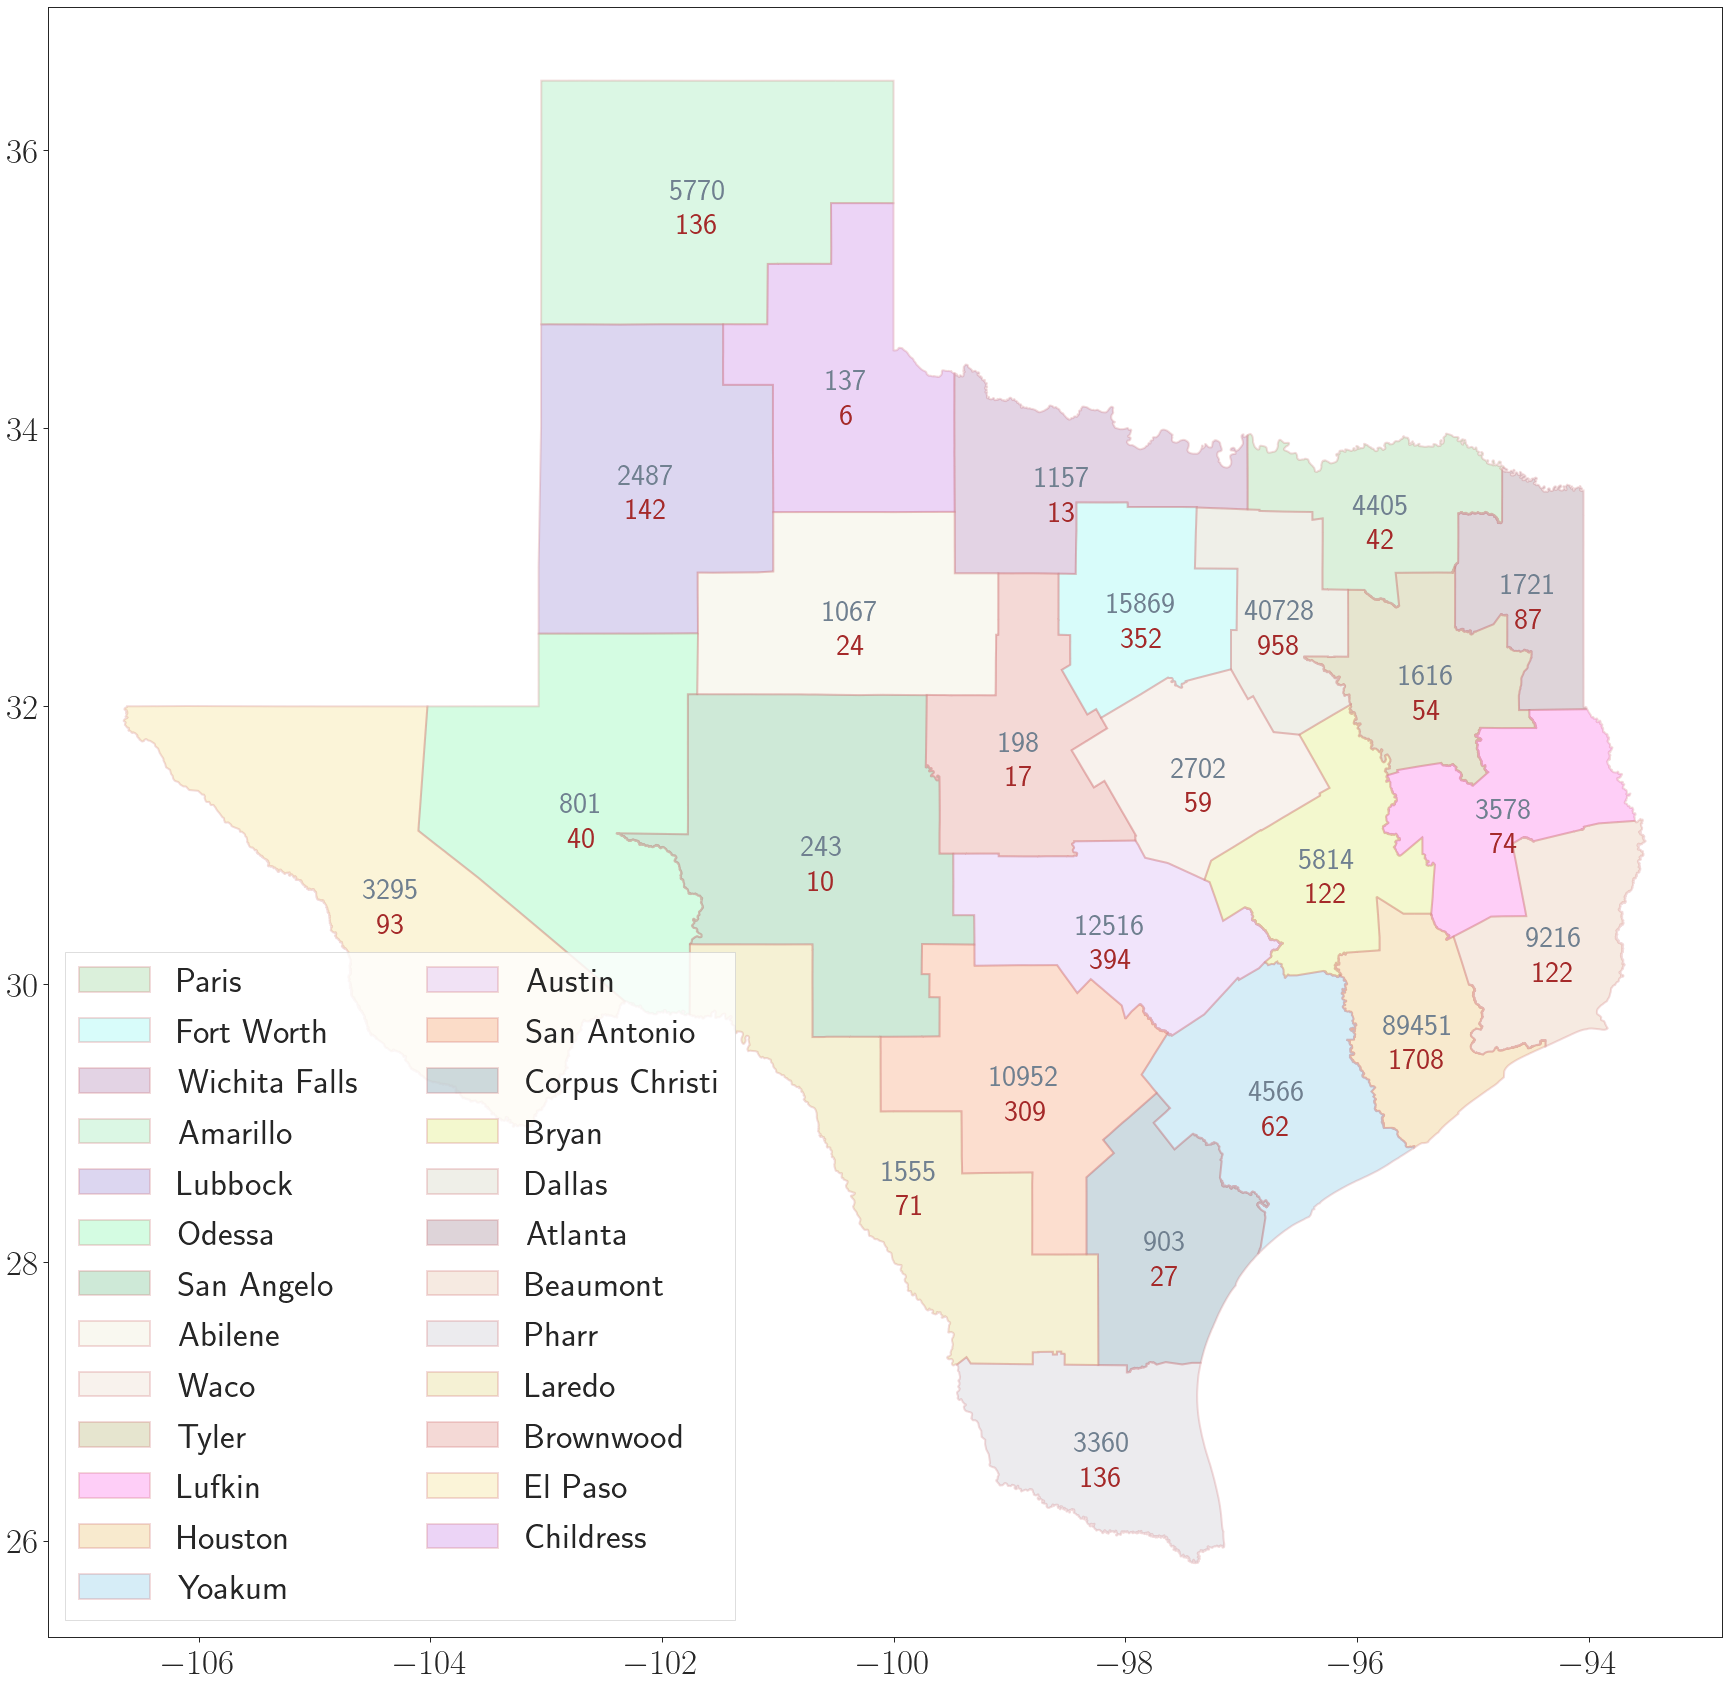

In [17]:
from descartes import PolygonPatch
sns.set_style("ticks")

fig = plt.figure(figsize=(30, 30))
plt.autoscale(enable=True, axis='both')
plt.gca().set_facecolor("white")

district_names = [r'Paris',r'Fort Worth',r'Wichita Falls', r'Amarillo', r'Lubbock', r'Odessa',\
                  r'San Angelo', r'Abilene', r'Waco', r'Tyler', r'Lufkin', r'Houston', r'Yoakum',\
                  r'Austin', r'San Antonio', r'Corpus Christi', r'Bryan', r'Dallas', r'Atlanta',\
                  r'Beaumont', r'Pharr', r'Laredo', r'Brownwood', r'El Paso', r'Childress']

# prediction time (last day)

# Aug 15
prediction_time = 92 - 1 - 17

# Sep 1
# prediction_time = 92 - 1

def get_point(i, nodes):
    return [nodes[i][0], nodes[i][1]]

def get_tri_nodes(i, nodes, elems):
    vx = []
    vy = []
    for j in range(3):
        v = get_point(elems[4*i+j+1], nodes)
        vx.append(v[0])
        vy.append(v[1])
        
    return vx, vy

def get_polygon(i, nodes, elems):
    
    v1 = get_point(elems[4*i+1], nodes)
    v2 = get_point(elems[4*i+2], nodes)
    v3 = get_point(elems[4*i+3], nodes)
    #return Polygon(((v1[0], v1[1]), (v2[0], v2[1]), (v3[0], v3[1])))
    #return Polygon([v1, v2, v3], closed=False, color=np.random.rand(3,), alpha=0.5, fill=True, edgecolor=None)
    return Polygon([v1, v2, v3], closed=False, alpha=0.5, fill=True, edgecolor=None)

def plot_tri():
    for i in range(mesh.n_cells):
        #ax.add_patch(get_polygon(i, mesh_nodes, mesh_elems))
        tri = get_polygon(i, mesh_nodes, mesh_elems)
        plt.gca().add_patch(tri)

        vx, vy = get_tri_nodes(i, mesh_nodes, mesh_elems)
        vx_mid = np.mean(vx)
        vy_mid = np.mean(vy)
        #plt.text(vx_mid, vy_mid, str(i), fontsize=8)
        
def plot_dist():
    ax = fig.gca() 
    for i in range(len(new_dist_geom)):
        poly = new_dist_geom[i]
        ax.add_patch(PolygonPatch(poly, fill=True, fc=cmap_dist[i], 
                        ec='r', alpha=0.2, zorder=2, linewidth=2, label = district_names[i]))
        
        plt.text(poly.centroid.xy[0][0], poly.centroid.xy[1][0], 
                 str(int(total_qoi_evolution[prediction_time, i, 0, 0])), 
                 ha='center', va='center', fontsize='30', color='slategrey', fontweight='bold')
        plt.text(poly.centroid.xy[0][0], poly.centroid.xy[1][0] - 0.25, 
                 str(int(total_qoi_evolution[prediction_time, i, 0, 1])), 
                 ha='center', va='center', fontsize='30', color='brown', fontweight='bold')
    


# plot_tri()
plot_dist()
plt.legend(ncol = 2, fancybox=False)
# plt.title('District-wise prediction on {}'.format(get_sim_date(prediction_time+1).date()))
plt.savefig('map_plot_cases_in_district_{}.png'.format(get_sim_date(prediction_time+1).date()))
plt.show()